## Identifying Artist from Art

The goal of this work is build a neural network capable to analyze some painting and classify their respective artists.

For that we are using the dataset [**Best Artworks of All Time**](https://www.kaggle.com/ikarus777/best-artworks-of-all-time).

**Read Data**

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers

In [2]:
# Creating the datasets.

image_height = 256
image_width = 256

args = {
    'directory': 'archive/images/images',
    'batch_size': 32,
    'image_size': (image_height, image_width),
    'validation_split': 0.3,
    'seed': 123
}

train_ds = tf.keras.preprocessing.image_dataset_from_directory(**args, subset='training')

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(**args, subset='validation')

Found 8774 files belonging to 51 classes.
Using 6142 files for training.
Found 8774 files belonging to 51 classes.
Using 2632 files for validation.


In [3]:
# artists_df = pd.read_csv('archive/artists.csv')
# useful_artists = list(artists_df[(artists_df['paintings'] > 100) & (artists_df['paintings'] < 700)]['name'])
# useful_artists = [x.replace(' ', '_') for x in useful_artists]

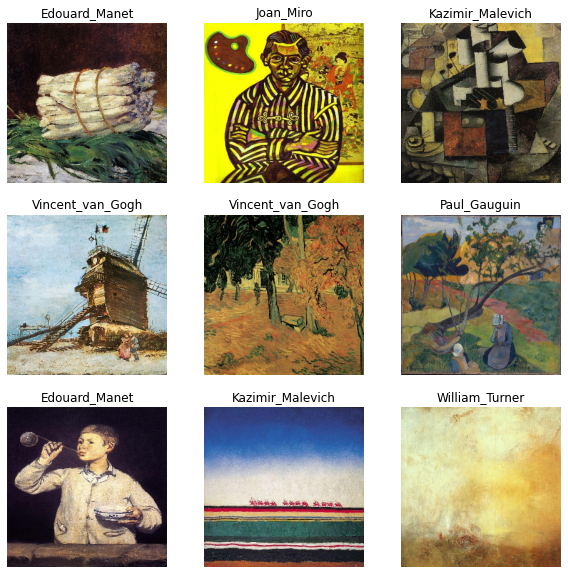

In [4]:
# Visualize the data: here are the first 9 images from the training dataset.

plt.figure(figsize=(10, 10))

class_names = train_ds.class_names

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [5]:
# Configure the dataset for performance.
#
# https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

**Data Augmentation**

In [6]:
data_augmentation = []

data_augmentation.append(layers.experimental.preprocessing.RandomFlip('horizontal',
                                                                      input_shape=(image_height, image_width, 3)))
data_augmentation.append(layers.experimental.preprocessing.RandomRotation(0.1))
data_augmentation.append(layers.experimental.preprocessing.RandomZoom(0.1))

**Build Model**

In [7]:
model = models.Sequential()

# model.add(models.Sequential(data_augmentation))

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu')) # Softmax could be an alternative.
model.add(layers.Dense(len(class_names)))

In [9]:
# Compile and train the model.

epochs = 5

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs)

In [ ]:
model.summary()

**Visualize Results**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()